In [1]:
import torchvision.datasets as dsets
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)
num_epoch=20
batch_size=32
device='cuda'
data_root='./data'

import allocateGPU
allocateGPU.allocate_gpu()

Number of gpu avaliable:	1
Current GPU:	0
GPU name: 	GeForce RTX 2080 Ti


In [2]:
attacks=['no_attacks','omniscient','label_flipping','omniscient_aggresive']
attacker_list_labelflipping={'no_attacks':[],'omniscient':[],'label_flipping':[0],'omniscient_aggresive':[]}
attacker_list_omniscient={'no_attacks':[],'omniscient':[0],'label_flipping':[],'omniscient_aggresive':[0]}

In [14]:
class Agg_dataset(torch.utils.data.Dataset):
    '''
        denote n be the number of clients,
        each entry of dataset is a 2-tuple of (weight delta, labels):= (1 x n tensor, 1 x n tensor)
        honest clients are labeled 1, malicious clients are labeled 0
    '''
    def __init__(self,path,attacks):
        super(Agg_dataset).__init__() 
        data=torch.load(path,map_location='cpu')
        data_tensors=torch.cat([data[param] for param in data],0)
        self.data=data_tensors
        self.label=attacks/torch.sum(attacks)
        self.label=self.label
        self.center=torch.sum(data_tensors*self.label,1).view(-1,1)
        self.num_clients=attacks.shape[0]
        
    def __getitem__(self, index):
#         perm=torch.randperm(self.num_clients)
        data_out=self.data[index]
        label_out=self.label
        center_out=self.center[index]
        data_sorted=torch.sort(data_out)
        data_order=data_sorted[1]
        return data_out[data_order], [label_out[data_order],center_out]
#         return data_out,[label_out,center_out]
    def __len__(self):
        return self.data.shape[0]//100

In [15]:
def get_loader(attack):
    label=torch.ones(10)
    for i in attacker_list_labelflipping[attack]:
        label[i]=0
    for i in attacker_list_omniscient[attack]:
        label[i]=0
    path=f'./AggData/{attack}/FedAvg_0.pt'
    dataset=Agg_dataset(path,label)
    validation_split = .2
    shuffle_dataset = True
    random_seed= 42

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
    valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    return train_loader, test_loader

In [17]:
def train(net,train_loader,criterion,optimizer,device, on):
    net.to(device)
    for idx, (data,target) in enumerate(train_loader):
        data = data.to(device)
        target = target[on].to(device)
        optimizer.zero_grad()   
        output = net(data)
        loss = criterion(output[on], target)
        loss.backward()
        optimizer.step()
    
def test(net,test_loader,device,message_prefix):
    net.to(device)
    accuracy = 0
    accuracy_mean = 0
    accuracy_median = 0
    count = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target[1].to(device)
            outputs = net(data)
            accuracy+=F.l1_loss(outputs[1], target)
            accuracy_mean+=F.l1_loss(data.mean(1).view(-1,1), target)
            accuracy_median+=F.l1_loss(data.median(1)[0].view(-1,1), target)
            count+=len(data)
    print('Accuracy: %.4E (%.4E, %.4E)' % (accuracy/count,accuracy_mean/count,accuracy_median/count ))
    return accuracy/count, accuracy_mean/count, accuracy_median/count

In [195]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
def dot_product(A,B):
    return torch.bmm(A.view(A.shape[0],1,A.shape[1]),B.view(B.shape[0],B.shape[1],1))
class Mlp(nn.Module):
    def __init__(self,n,in_dim):
        super(Mlp, self).__init__()
        self.in_dim=in_dim
        self.fc1 = nn.Linear(self.in_dim, n,bias=False)
        self.fc2 = nn.Linear(n, n,bias=False)
        self.fc3 = nn.Linear(n, self.in_dim,bias=False)

    def forward(self, input):
        x = input.view(-1, self.in_dim)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1)
        pred=dot_product(x,input).squeeze(-1)
    
        return x,pred

In [197]:
class CNN(nn.Module):
    def __init__(self,n,in_dim):
        super(CNN, self).__init__()
        self.in_dim=in_dim
        self.fc1 = nn.Conv1d(1, n, kernel_size=3,dilation=1, padding=1)
        self.fc2 = nn.Conv1d(n, n, kernel_size=3,dilation=2, padding=2)
        self.fc3 = nn.Conv1d(n, self.in_dim, kernel_size=3,dilation=1, padding=1)
        self.maxpool1=nn.AdaptiveMaxPool1d(1)
        

    def forward(self, input):
        x = input.view(-1, 1, self.in_dim)
        x = nn.LeakyReLU()(self.fc1(x))
        x = nn.LeakyReLU()(self.fc2(x))
        x = nn.LeakyReLU()(self.fc3(x))
        x = self.maxpool1(x)

        x=x.squeeze()
        x = F.softmax(x,dim=1)
        pred=dot_product(x,input).squeeze(-1)
        return x, pred

In [200]:
from tensorboardX import SummaryWriter
def write(name,scalar):
    writer=SummaryWriter(f'./agg_logs/{name}')
    writer.add_scalar('l1 loss', scalar, 0)
    writer.close()

In [201]:
accuracy_list={}


In [202]:
loaders={attack:get_loader(attack) for attack in attacks}


In [ ]:
mode_name=['classification','regression']
for attack in attacks:
    train_loader, test_loader=loaders[attack]
    for criterion in [torch.nn.L1Loss()]:
        for mode in [0,1]:
            net_cnn=CNN(32,10)
            net_mlp=Mlp(10,10)

            for net in [net_cnn,net_mlp]:
                
                training_alias=f'{attack}/{net.__class__.__name__}/{mode_name[mode]}/{criterion.__class__.__name__}'
                if training_alias in accuracy_list:
                    continue
                
                print('Start training of %s'%training_alias)
                optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)
                for epoch in range(1):
                    train(net,train_loader,criterion,optimizer,device,mode)
                    score=test(net,test_loader,device,'')
                write(training_alias,score[0])
                accuracy_list[training_alias]=score[0].item()
    accuracy_list[f'{attack}/mean']=score[1].item()
    write(f'{attack}/mean',score[1])
    accuracy_list[f'{attack}/median']=score[2].item()
    write(f'{attack}/median',score[1])

## Compare the results

In [39]:
accuracy_list

{'no_attacks/Mlp/classification/L1Loss': 2.2635820995375866e-10,
 'no_attacks/CNN/classification/L1Loss': 5.723303786453471e-08,
 'no_attacks/Mlp/regression/L1Loss': 8.204105728104594e-10,
 'no_attacks/CNN/regression/L1Loss': 4.139364051525263e-08,
 'no_attacks/mean': 2.941553250979112e-12,
 'no_attacks/median': 1.372522547171684e-06,
 'omniscient/Mlp/classification/L1Loss': 7.797454600222409e-05,
 'omniscient/CNN/classification/L1Loss': 8.67093913257122e-05,
 'omniscient/Mlp/regression/L1Loss': 7.764556357869878e-05,
 'omniscient/CNN/regression/L1Loss': 7.513722084695473e-05,
 'omniscient/mean': 7.790404924890026e-05,
 'omniscient/median': 1.8102322201229981e-06,
 'label_flipping/Mlp/classification/L1Loss': 7.47312742532813e-06,
 'label_flipping/CNN/classification/L1Loss': 7.302185167645803e-06,
 'label_flipping/Mlp/regression/L1Loss': 7.4711942943395115e-06,
 'label_flipping/CNN/regression/L1Loss': 7.207338057924062e-06,
 'label_flipping/mean': 7.472800916730193e-06,
 'label_flipping

In [40]:
import pandas as pd
from collections import OrderedDict  

In [73]:
struct=[key.split('/',1)+[accuracy_list[key]] for key  in accuracy_list.keys()]
df=pd.DataFrame(np.array([row[2] for row in struct]).reshape(4,6))


index=list(OrderedDict.fromkeys([row[0] for row in struct]))
df.index=index

columns=list(OrderedDict.fromkeys([row[1] for row in struct]))
df.columns=columns

In [76]:
df

,Mlp/classification/L1Loss,CNN/classification/L1Loss,Mlp/regression/L1Loss,CNN/regression/L1Loss,mean,median
no_attacks,2.263582e-10,5.723304e-08,8.204106e-10,4.139364e-08,2.941553e-12,0.000001
omniscient,7.797455e-05,8.670939e-05,7.764556e-05,7.513722e-05,7.790405e-05,0.000002
label_flipping,7.473127e-06,7.302185e-06,7.471194e-06,7.207338e-06,7.472801e-06,0.000002
omniscient_aggresive,7.797606e-05,7.980704e-05,7.780743e-05,7.506809e-05,7.790414e-05,0.000002


In [89]:
def highlight_max(s):
    '''
    highlight the minimum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

print("\nHighlight the minimum value in each column:")
df.T.style.apply(highlight_max,subset=pd.IndexSlice[:, df.T.columns])


Highlight the maximum value in each column:


,no_attacks,omniscient,label_flipping,omniscient_aggresive
Mlp/classification/L1Loss,2.26358e-10,7.79745e-05,7.47313e-06,7.79761e-05
CNN/classification/L1Loss,5.7233e-08,8.67094e-05,7.30219e-06,7.9807e-05
Mlp/regression/L1Loss,8.20411e-10,7.76456e-05,7.47119e-06,7.78074e-05
CNN/regression/L1Loss,4.13936e-08,7.51372e-05,7.20734e-06,7.50681e-05
mean,2.94155e-12,7.7904e-05,7.4728e-06,7.79041e-05
median,1.37252e-06,1.81023e-06,1.8067e-06,1.81087e-06


## Visualize distribution of gradients

In [170]:
attack=attacks[1]
label=torch.ones(10)
for i in attacker_list_labelflipping[attack]:
    label[i]=0
for i in attacker_list_omniscient[attack]:
    label[i]=0
path=f'./AggData/{attack}/FedAvg_0.pt'
dataset=Agg_dataset(path,label)
dist=dataset.center.numpy()

In [171]:
df=pd.DataFrame(np.log(np.abs(dist))).replace([np.inf, -np.inf], np.nan)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d1c42c668>]],
      dtype=object)

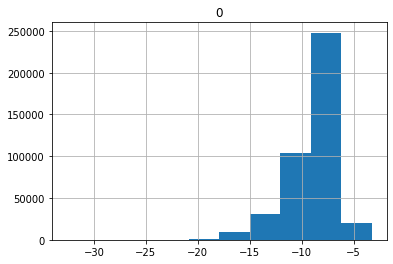

In [175]:
df.hist()

In [173]:
df.quantile([0.25,0.75])

,0
0.25,-9.903770
0.75,-7.301964
